In [87]:
#following example at https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation

import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [108]:
def animate(snapshots, file_name = "animation.gif"):


    fps = 30
    nSeconds = len(snapshots)/fps
    # snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

    # a=output
    # snapshots = output
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-2.5, vmax=2.5)
    plt.colorbar()
    
    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)#, fps=30)


    print('Done! gif saved to ', file_name)

    # plt.show()  # Not required, it seems!

In [91]:
#loading data
data_path = '../data/npy/toy1.npy'
data = np.load(data_path)
print("data shape = ", data.shape)
data = torch.tensor(data).unsqueeze(1).float()
print("data shape = ", data.shape)

# dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)
dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=0, train_ratio=1.0,  valid_ratio=0.0, shuffle = False)
data,_,_ = dataset.obtain_data_at_current_level(level=0)

# Converting data to torch.FloatTensor
# transform = transforms.ToTensor()

# # Download the training and test datasets
# train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# print("train_data shape = ", len(train_data))

data shape =  (500, 127, 127)
data shape =  torch.Size([500, 1, 127, 127])


In [3]:
# #Prepare data loaders
train_loader = torch.utils.data.DataLoader(data, batch_size=50, num_workers=0)
# print(len(train_loader))
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=31, num_workers=0)

images shape =  (50, 1, 31, 31)


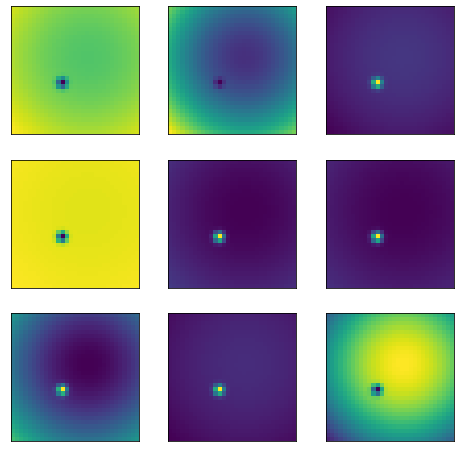

In [4]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display

print("images shape = ", images.shape)
#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

In [57]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.convfirst = nn.Conv2d(1, 1, 3, stride = 2, padding=0)  
        self.conv1 = nn.Conv2d(1, 1, 3, stride = 1, padding=1)  
#         self.conv2 = nn.Conv2d(1, 4, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=1)
        self.t_conv_last = nn.ConvTranspose2d(1, 1, 3, stride=2, padding=0)


    def forward(self, x):
        print("x start = ", x.shape)
        x = F.relu(self.convfirst(x))
        print("x 1 = ", x.shape)
        x = F.relu(self.conv1(x))
        print("x 1 = ", x.shape)
        x = F.relu(self.conv1(x))
        print("x middle = ", x.shape)
#         x = self.pool(x)
#         print("x 2 = ", x.shape)
#         x = F.relu(self.conv2(x))
#         
#         x = self.pool(x)
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
        print("x pad = ", x.shape)
        x = F.relu(self.t_conv1(x))
        print("x 4 = ", x.shape)
        x = F.relu(self.t_conv1(x))
        print("x 4 = ", x.shape)
        x = F.sigmoid(self.t_conv_last(x))
        print("x before cut = ", x.shape)
        x = x[:, :, 2:-2, 2:-2]
        print("x end = ", x.shape)
#         gh
#         hjj
        return x

    def encode(self, x):
        x = F.relu(self.convfirst(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1(x))
        return x
    
    def decode(self, x):
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv_last(x))
        x = x[:, :, 2:-2, 2:-2]
        
        return x

#Instantiate the model
model = ConvAutoencoder()
print(model)
model(images)

ConvAutoencoder(
  (convfirst): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv1): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv_last): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
)
x start =  torch.Size([50, 1, 31, 31])
x 1 =  torch.Size([50, 1, 15, 15])
x 1 =  torch.Size([50, 1, 15, 15])
x middle =  torch.Size([50, 1, 15, 15])
x pad =  torch.Size([50, 1, 17, 17])
x 4 =  torch.Size([50, 1, 17, 17])
x 4 =  torch.Size([50, 1, 17, 17])
x before cut =  torch.Size([50, 1, 35, 35])
x end =  torch.Size([50, 1, 31, 31])


tensor([[[[0.4915, 0.5373, 0.4741,  ..., 0.4673, 0.5430, 0.4782],
          [0.5312, 0.5343, 0.5303,  ..., 0.5216, 0.5353, 0.5204],
          [0.4950, 0.5365, 0.4709,  ..., 0.4587, 0.5407, 0.4673],
          ...,
          [0.4958, 0.5374, 0.4739,  ..., 0.4627, 0.5384, 0.4698],
          [0.5325, 0.5343, 0.5297,  ..., 0.5231, 0.5351, 0.5215],
          [0.4986, 0.5356, 0.4803,  ..., 0.4718, 0.5350, 0.4753]]],


        [[[0.4915, 0.5373, 0.4741,  ..., 0.4673, 0.5430, 0.4782],
          [0.5312, 0.5343, 0.5303,  ..., 0.5216, 0.5353, 0.5204],
          [0.4950, 0.5365, 0.4709,  ..., 0.4587, 0.5407, 0.4673],
          ...,
          [0.4958, 0.5374, 0.4739,  ..., 0.4627, 0.5384, 0.4698],
          [0.5325, 0.5343, 0.5297,  ..., 0.5231, 0.5351, 0.5215],
          [0.4986, 0.5356, 0.4803,  ..., 0.4718, 0.5350, 0.4753]]],


        [[[0.4915, 0.5373, 0.4741,  ..., 0.4673, 0.5430, 0.4782],
          [0.5312, 0.5343, 0.5303,  ..., 0.5216, 0.5353, 0.5204],
          [0.4950, 0.5365, 0.4709,  ..

In [55]:
#Loss function
criterion = nn.BCELoss()
# criterion = nn.MSELoss()#reduction='none')

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (convfirst): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv1): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv_last): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [56]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

#     i = 0
    #Training
    for data in train_loader:
#         i += 1
#         if i % 100 == 0:
#             print('i: {} \tTraining Loss: {:.6f}'.format(i, train_loss/i))
#             break
        images = data
#         print(images.shape)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
#         print(outputs.shape)
#         fghj
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
Epoch: 1 	Training Loss: 36.483498
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.Size([50, 1, 31, 31])
x middle =  torch.Size([50, 1, 15, 15])
x start =  torch.

KeyboardInterrupt: 

(50, 1, 31, 31)
image_min =  -2.4598024
image_max =  2.4965377
output min =  0.0
output max =  0.7139813
Original Images
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)


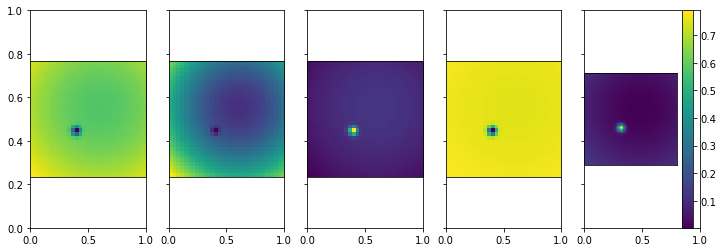

Reconstructed Images


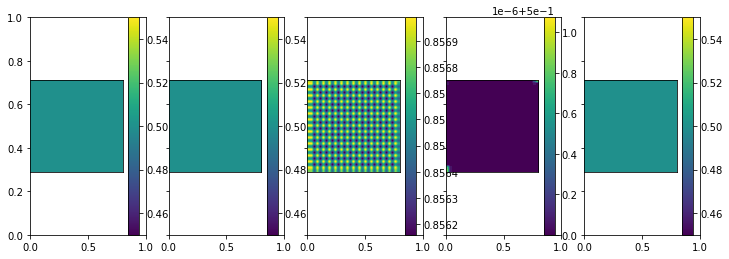

In [47]:
#Batch of test images
dataiter = iter(train_loader)
images = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

print(images.shape)
batch_size = 50
output = output.view(batch_size, 1, 31, 31)#127, 127)
output = output.detach().numpy()

image_min = np.min(images)
image_max = np.max(images)
print("image_min = ", image_min)
print("image_max = ", image_max)

print("output min = ", np.min(output))
print("output max = ", np.max(output))
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    print(images[idx][0].shape)
    imshow(images[idx])#[0], vmin = -2.5, vmax = 2.5)
#     ax.set_title(classes[labels[idx]])
plt.colorbar()
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    plt.colorbar()
#     ax.set_title(classes[labels[idx]])
plt.show() 

torch.Size([10, 1, 31, 31])
(10, 1, 15, 15)


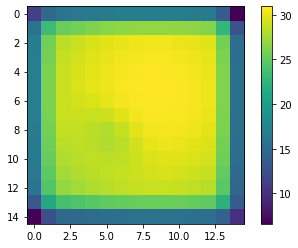

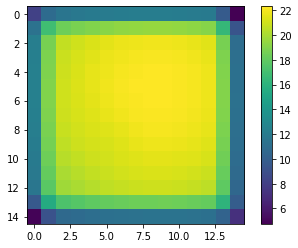

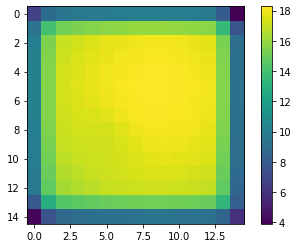

In [48]:
#Batch of test images
# dataiter = iter(train_loader)
# images = dataiter.next()
images = data[:10, :,:,:]
print(images.shape)
#encode and plot

encoded = model.encode(images).detach().numpy()
print(encoded.shape)

#encoded Images
plt.figure()
plt.imshow(encoded[0,0,:,:])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(encoded[1,0,:,:])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(encoded[2,0,:,:])
plt.colorbar()
plt.show()
# fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
# for idx in np.arange(5):
#     ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
#     imshow(encoded[idx])
# #     ax.set_title(classes[labels[idx]])
#     plt.colorbar()
# plt.show()

In [ ]:
import matplotlib.animation as animation
data_path = '../data/npy/toy1.npy'
data = np.load(data_path)
print("data shape = ", data.shape)
data = torch.tensor(data).unsqueeze(1).float()
print("data shape = ", data.shape)
print(data.shape)
# ghj
output = model(data)#.numpy()

print(images.shape)
batch_size = 500
output = output.view(batch_size, 1, 127, 127)
output = output.detach().numpy()

fps = 30
nSeconds = 50/fps
# snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

# a=output
snapshots = output
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0,:,:,:][0].T
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-2.5, vmax=2.5)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i,:,:,:,][0].T)
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )
writergif = animation.PillowWriter(fps=30)
anim.save('Toy_1_Phi_simple_reconstruct.gif', writer=writergif)#, fps=30)


print('Done!')

# plt.show()  # Not required, it seems!

In [106]:

class MultiScaleDynamicsDataSet():
    def __init__(self, data_path, n_levels, t_array = None, map_path=None, train_ratio=0.7, valid_ratio=0.2, shuffle=True):
        # load data
        data = np.load(data_path)
        self.data = torch.tensor(data).unsqueeze(1).float()
        if t_array is None:
            self.t_array = torch.range(len(self.data)).float()
        else:
            self.t_array = torch.tensor(t_array).float()
        #
        if map_path is not None:
            map_data = 1 - np.load(map_path)
            self.map_data = torch.tensor(map_data).float()
        else:
            self.map_data = torch.ones(data.shape[-2:]).float()

        self.nt, self.nx, self.ny = data.shape
        # partition
        indices = np.arange(self.nt)
        if shuffle:
            np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.map_data = self.map_data.to(self.device)

    def obtain_data_at_current_level(self, level):
        train_data = self.data[self.train_inds].to(self.device)

        val_data = self.data[self.val_inds].to(self.device)
        test_data = self.data[self.test_inds].to(self.device)
        
        for i in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data
    
    def get_times(self):
        train_times = self.t_array[self.train_inds]
        val_times = self.t_array[self.val_inds]
        test_times = self.t_array[self.test_inds]
        
        return train_times, val_times, test_times

    def obtain_data_of_size(self, size_per_dim):
        train_data = self.data[self.train_inds].to(self.device)
        
        
        n_images, _, nx, ny = train_data.shape
#         print("n_images = ", n_images)
#         print("nx = ", nx)
#         print("ny = ", ny)
        
        stride_size = int(nx/size_per_dim)
#         print("stride_size = ", stride_size)
        
        op = torch.nn.Conv2d(1, 1, stride_size, stride=stride_size, padding=0).to(device)
#         print("op.weight.data= ", op.weight.data.shape)
        n = 1
        for i in range(n):
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / (stride_size **2)
        new_train_data = op(train_data)
#         print("new_train_data shape = ", new_train_data.shape)
        
#         for i in range(self.n_levels - 1):
#             train_data = apply_local_op(train_data, self.device, ave=False)

        return new_train_data
        
        
        
def apply_local_op(data, device, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels, _, _ = data.size()
    print("data size = ", data.shape)
    n = min(in_channels, out_channels)
    if mode == 'conv':
        op = torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    elif mode == 'deconv':
        op = torch.nn.ConvTranspose2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    else:
        raise ValueError('mode can only be conv or deconv!')
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)

    for i in range(n):
        if mode == 'conv':
            if ave:
                op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 9
            else:
                op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size()).to(device)
        elif mode == 'deconv':
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 4
            op.weight.data[i, i, 0, 1] += 1 / 4
            op.weight.data[i, i, 1, 0] += 1 / 4
            op.weight.data[i, i, 1, 2] += 1 / 4
            op.weight.data[i, i, 2, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 2

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    return op(data)

t = np.linspace(0, 8*np.pi, 500)
dataset_new = MultiScaleDynamicsDataSet(data_path, t, n_levels=3, train_ratio=1.0, valid_ratio=0.0, shuffle=False)
data_new = dataset_new.obtain_data_of_size(2).detach().numpy()
train_times, _, _ = dataset_new.get_times()

print(train_times)

n_images =  500
nx =  127
ny =  127
stride_size =  63
op.weight.data=  torch.Size([1, 1, 63, 63])
new_train_data shape =  torch.Size([500, 1, 2, 2])
tensor([[ 0.0000],
        [ 0.0504],
        [ 0.1007],
        [ 0.1511],
        [ 0.2015],
        [ 0.2518],
        [ 0.3022],
        [ 0.3526],
        [ 0.4029],
        [ 0.4533],
        [ 0.5037],
        [ 0.5540],
        [ 0.6044],
        [ 0.6548],
        [ 0.7051],
        [ 0.7555],
        [ 0.8059],
        [ 0.8562],
        [ 0.9066],
        [ 0.9570],
        [ 1.0073],
        [ 1.0577],
        [ 1.1081],
        [ 1.1584],
        [ 1.2088],
        [ 1.2592],
        [ 1.3095],
        [ 1.3599],
        [ 1.4103],
        [ 1.4606],
        [ 1.5110],
        [ 1.5614],
        [ 1.6117],
        [ 1.6621],
        [ 1.7125],
        [ 1.7628],
        [ 1.8132],
        [ 1.8635],
        [ 1.9139],
        [ 1.9643],
        [ 2.0146],
        [ 2.0650],
        [ 2.1154],
        [ 2.1657],
        [ 2.216

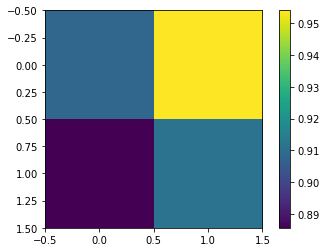

Animating, may take a little while...
..................Done! gif saved to  2x2.gif


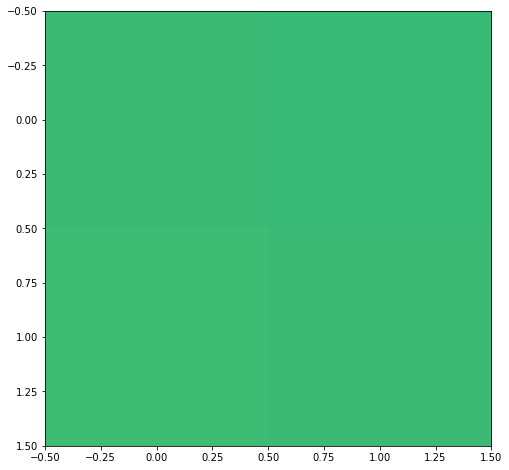

In [107]:
plt.figure()
plt.imshow(data_new[0][0])
plt.colorbar()
plt.show()

animate(data_new, file_name = "2x2.gif")

Animating, may take a little while...
...Done! gif saved to  2x2_small.gif


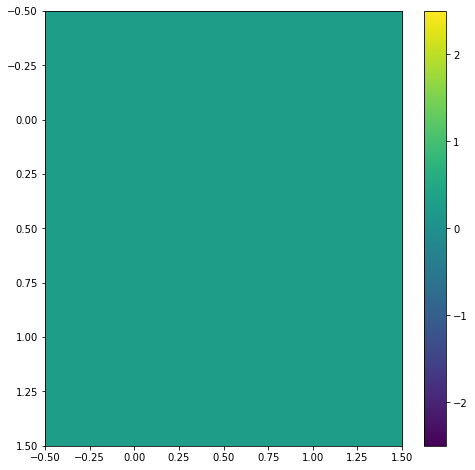

In [109]:
animate(data_new[:50], file_name = "2x2_small.gif")